# DX 704 Week 1 Project

This week's project will build a portfolio risk and return model, and make investing recommendations for hypothetical clients.
You will collect historical data, estimate returns and risks, construct efficient frontier portfolios, and sanity check the certainty of the maximum return portfolio.

The full project description and a template notebook are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-01


Feel free to use optimization tools or libraries (such as CVXOPT or scipy.optimize) to perform any calculations required for this mini project.

### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

In [60]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

## Part 1: Collect Data

Collect historical monthly price data for the last 24 months covering 6 different stocks.
The data should cover 24 consecutive months including the last month that ended before this week's material was released on Blackboard.
To be clear, if a month ends between the Blackboard release and submitting your project, you do not need to add that month.

The six different stocks must include AAPL, SPY and TSLA.
At least one of the remaining 3 tickers must start with the same letter as your last name (e.g. professor Considine could use COIN).
This is to encourage diversity in what stocks you analyze; if you discuss this project with classmates, please make sure that you pick different tickers to differentiate your work.
Do not pick stocks with fewer than 24 consecutive months of price data.

In [61]:
# Define the 6 stock tickers
# Must include: AAPL, SPY, TSLA
# At least one starting with the same letter as last name (T for "Tbran")
tickers = ['AAPL', 'SPY', 'TSLA', 'ZM', 'DT', 'BUD']

historical_prices = None

for t in tickers:
    ticker = yf.Ticker(t)
    history =  ticker.history(period="2y")

    monthly_prices = history['Close'].resample('ME').last()

    if historical_prices is None:
        historical_prices = monthly_prices
    else:
        historical_prices = pd.concat([historical_prices, monthly_prices], axis=1)

historical_prices = historical_prices.iloc[:-1]

historical_prices.columns = tickers
historical_prices.index = pd.to_datetime(historical_prices.index).strftime("%Y-%m-%d")

historical_prices


,AAPL,SPY,TSLA,ZM,DT,BUD
Date,,,,,,
2024-01-31,182.674820,471.230682,187.289993,64.610001,57.000000,59.803589
2024-02-29,179.287476,495.822693,201.880005,70.730003,49.549999,58.476559
2024-03-31,170.092468,512.037109,175.789993,65.370003,46.439999,58.873699
2024-04-30,168.951767,491.391937,183.279999,61.099998,45.310001,57.788826
2024-05-31,190.953064,516.246338,178.080002,61.340000,45.730000,61.994518
2024-06-30,209.199142,534.459595,197.880005,59.189999,44.740002,57.158417
2024-07-31,220.581818,540.931396,232.070007,60.400002,43.919998,58.485397
2024-08-31,227.718414,553.570740,214.110001,69.080002,50.619999,60.392315
2024-09-30,231.696045,565.198120,261.630005,69.739998,53.470001,65.159615


Save the data as a TSV file named "historical_prices.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
The date should be the last trading day of the month, so it may not be the last day of the month.
For example, the last trading day of November 2024 was 2024-11-29.
The remaining columns should contain the adjusted closing prices of the corresponding stock tickers on that day.


In [62]:
# YOUR CHANGES HERE

historical_prices.to_csv('historical_prices.tsv', sep='\t')


Submit "historical_prices.tsv" in Gradescope.

## Part 2: Calculate Historical Asset Returns

Calculate the historical asset returns based on the price data that you previously collected.

In [63]:
# Calculate month-over-month returns
historical_returns = historical_prices.pct_change().dropna()

print(f"Returns shape: {historical_returns.shape}")
print("\nFirst few rows:")
print(historical_returns.head())


Returns shape: (23, 6)

First few rows:
                AAPL       SPY      TSLA        ZM        DT       BUD
Date                                                                  
2024-02-29 -0.018543  0.052187  0.077901  0.094722 -0.130702 -0.022190
2024-03-31 -0.051286  0.032702 -0.129235 -0.075781 -0.062765  0.006791
2024-04-30 -0.006706 -0.040320  0.042608 -0.065321 -0.024332 -0.018427
2024-05-31  0.130222  0.050580 -0.028372  0.003928  0.009269  0.072777
2024-06-30  0.095553  0.035280  0.111186 -0.035051 -0.021649 -0.078009


Save the data as a TSV file named "historical_returns.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
Each row should have the date at the end of the month and the corresponding *relative* price changes.
For example, if the previous price was \$100 and the new price is \$110, the return value should be 0.10.
There should only be 23 rows of data in this file, since they are computed as the differences of 24 prices.

In [64]:
# YOUR CHANGES HERE
# Convert index to string format and save to TSV file
historical_returns_with_date = historical_returns.copy()
historical_returns_with_date.index = historical_returns_with_date.index.astype(str)

historical_returns_with_date.to_csv('historical_returns.tsv', sep='\t')

Submit "historical_returns.tsv" in Gradescope.

## Part 3: Estimate Returns

Estimate the expected returns for each asset using the previously calculated return data.
Just compute the average (mean) return for each asset over your data set; do not use other estimators that have been mentioned.
This will serve as your estimate of expected return for each asset.

In [65]:
# YOUR CHANGES HERE
estimated_returns = historical_returns.mean().rename("return")
estimated_returns.sort_values()

DT     -0.008969
BUD     0.006059
ZM      0.014924
SPY     0.016666
AAPL    0.019069
TSLA    0.049640
Name: return, dtype: float64

Save the estimated returns in a TSV file named "estimated_returns.tsv" and include a header row with the column names "asset" and "estimated_return".

In [66]:
# YOUR CHANGES HERE

estimated_returns.to_frame().reset_index().rename(columns={'index': 'asset', 'return': 'estimated_return'}).to_csv('estimated_returns.tsv', sep='\t', index=False)

Submit "estimated_returns.tsv" in Gradescope.

## Part 4: Estimate Risk

Estimate the covariance matrix for the asset returns to understand how the assets move together.

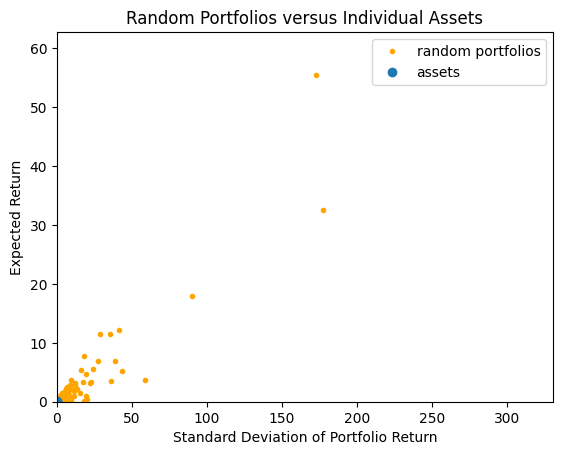

In [67]:
# YOUR CHANGES HERE
estimated_variances = historical_returns.var()

estimated_covariance = historical_returns.cov()

np.random.seed(704)
random_portfolios = np.random.geometric(0.01, size=(10000, len(tickers)))**5
random_portfolios = random_portfolios / random_portfolios.sum(axis=1)[:, None]

random_returns = random_portfolios @ estimated_returns
random_variances = [random_portfolios[i,:] @ estimated_covariance @ random_portfolios[i,:].T for i in range(len(random_portfolios))]

plt.plot(np.sqrt(random_variances), random_returns, label="random portfolios", linestyle="none", marker=".", color="orange")
plt.plot(np.sqrt(estimated_variances), estimated_returns, label="assets", linestyle="none", marker="o")

plt.legend()
plt.xlabel("Standard Deviation of Portfolio Return")
plt.xlim(0)
plt.ylabel("Expected Return")
plt.ylim(0)
plt.title("Random Portfolios versus Individual Assets")

plt.show();

Save the estimated covariances to a TSV file named "estimated_covariance.tsv".
The header row should have a blank column name followed by the names of the assets.
Each data row should start with the name of an asset for that row, and be followed by the individual covariances corresponding to that row and column's assets.
(This is the format of pandas's `to_csv` method with `sep="\t"` when used on a covariance matrix as computed in the examples.)

In [68]:
# YOUR CHANGES HERE

estimated_covariance.to_csv('estimated_covariance.tsv', sep='\t')

Submit "estimated_covariance.tsv" in Gradescope.

## Part 5: Construct the Maximum Return Portfolio

Compute the maximum return portfolio based on your previously estimated risks and returns.

In [69]:
# YOUR CHANGES HERE
# Compute maximum return portfolio using cvxpy
weights = cp.Variable(len(tickers))
objective = cp.Maximize(estimated_returns.values @ weights)
constraints = [cp.sum(weights) == 1, weights >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

np.float64(0.04963986696675771)

Save the maximum return portfolio in a TSV file named "maximum_return.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [70]:
# YOUR CHANGES HERE
# Create dataframe and save
max_return_portfolio = pd.DataFrame({
    'asset': tickers,
    'allocation': weights.value
})
max_return_portfolio.to_csv('maximum_return.tsv', sep='\t', index=False)

Submit "maximum_return.tsv" in Gradescope.

## Part 6: Construct the Minimum Risk Portfolio

Compute the minimum risk portfolio based on your previously estimated risks.

In [71]:
# YOUR CHANGES HERE

# Compute minimum risk portfolio using cvxpy
weights_min = cp.Variable(len(tickers))
objective_min = cp.Minimize(cp.quad_form(weights_min, estimated_covariance.values))
constraints_min = [cp.sum(weights_min) == 1, weights_min >= 0]
problem_min = cp.Problem(objective_min, constraints_min)
problem_min.solve()


np.float64(0.0007263409670769606)

Save the minimum risk portfolio in a TSV file named "minimum_risk.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [72]:
# YOUR CHANGES HERE

# Create dataframe and save
min_risk_portfolio = pd.DataFrame({
    'asset': tickers,
    'allocation': weights_min.value
})
min_risk_portfolio.to_csv('minimum_risk.tsv', sep='\t', index=False)

Submit "minimum_risk.tsv" in Gradescope.

## Part 7: Build Efficient Frontier Portfolios

Compute 101 portfolios along the mean-variance efficient frontier with evenly spaced estimated returns.
The first portfolio should be the minimum risk portfolio from part 4, and the last portfolio should be the maximum return portfolio from part 3.
The estimated return of each portfolio should be higher than the previous by one percent of the difference between the first and last portfolios.
That is, the estimated return of the portfolios should be similar to `np.linspace(min_risk_return, max_return, 101)`.


In [73]:
# YOUR CHANGES HERE

# Get returns from min and max portfolios
min_risk_return = weights_min.value @ estimated_returns.values
max_return = weights.value @ estimated_returns.values

# Create target returns for 101 portfolios
target_returns = np.linspace(min_risk_return, max_return, 101)

# Store efficient frontier portfolios
efficient_portfolios = []

for target_return in target_returns:
    # Optimize for minimum risk given target return constraint
    w = cp.Variable(len(tickers))
    objective = cp.Minimize(cp.quad_form(w, estimated_covariance.values))
    constraints = [cp.sum(w) == 1, w >= 0, estimated_returns.values @ w == target_return]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    portfolio_return = estimated_returns.values @ w.value
    portfolio_risk = np.sqrt(w.value @ estimated_covariance.values @ w.value)
    
    efficient_portfolios.append((portfolio_return, portfolio_risk, w.value))



Save the portfolios in a TSV file named "efficient_frontier.tsv".
The header row should have columns "index", "return", "risk", and all the asset tickers.
Each data row should have the portfolio index (0-100), the estimated return of the portfolio, the estimated standard deviation (not variance) of the portfolio, and all the asset allocations (which should sum to one).

In [74]:
# YOUR CHANGES HERE
# Create dataframe
ef_data = []
for idx, (ret, risk, alloc) in enumerate(efficient_portfolios):
    row = {'index': idx, 'return': ret, 'risk': risk}
    for i, ticker in enumerate(tickers):
        row[ticker] = alloc[i]
    ef_data.append(row)

efficient_frontier_df = pd.DataFrame(ef_data)
efficient_frontier_df.to_csv('efficient_frontier.tsv', sep='\t', index=False)

Submit "efficient_frontier.tsv" in Gradescope.

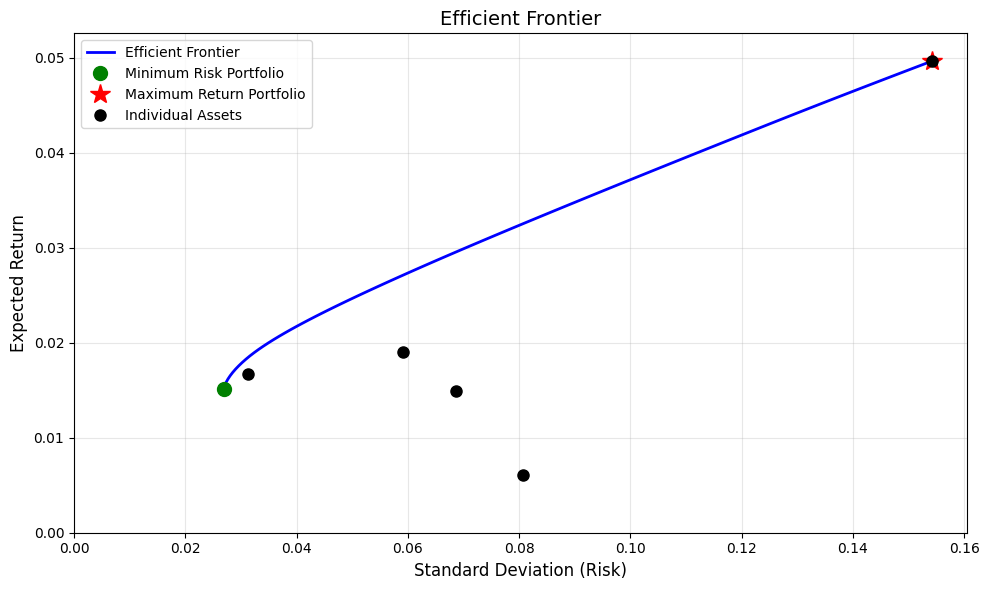

In [75]:
# Plot the efficient frontier
plt.figure(figsize=(10, 6))

# Plot efficient frontier
risks = [risk for _, risk, _ in efficient_portfolios]
returns = [ret for ret, _, _ in efficient_portfolios]
plt.plot(risks, returns, 'b-', linewidth=2, label='Efficient Frontier')

# Mark minimum risk portfolio
min_risk_idx = 0
plt.plot(risks[min_risk_idx], returns[min_risk_idx], 'go', markersize=10, label='Minimum Risk Portfolio')

# Mark maximum return portfolio
max_return_idx = 100
plt.plot(risks[max_return_idx], returns[max_return_idx], 'r*', markersize=15, label='Maximum Return Portfolio')

# Plot individual assets
plt.plot(np.sqrt(estimated_variances), estimated_returns, 'ko', markersize=8, label='Individual Assets')

# Labels and formatting
plt.xlabel('Standard Deviation (Risk)', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.title('Efficient Frontier', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()


## Part 8: Check Maximum Return Portfolio Stability

Check the stability of the maximum return portfolio by resampling the estimated risk/return model.

Repeat 1000 times -
1. Use `np.random.multivariate_normal` to generate 23 return samples using your previously estimated risks and returns.
2. Estimate the return of each asset using that resampled return history.
3. Check which asset had the highest return in those resampled estimates.

This procedure is a reduced and simplified version of the Michaud resampled efficient frontier procedure that takes uncertainty in the risk model into account.

In [76]:
# YOUR CHANGES HERE

# Resample 1000 times and track which asset has highest return
asset_counts = {ticker: 0 for ticker in tickers}

np.random.seed(704)
for _ in range(1000):
    # Generate 23 return samples from multivariate normal distribution
    resampled_returns = np.random.multivariate_normal(
        estimated_returns.values, 
        estimated_covariance.values, 
        size=23
    )
    
    # Estimate returns from resampled data
    resampled_mean_returns = resampled_returns.mean(axis=0)
    
    # Find asset with highest return
    max_return_idx = np.argmax(resampled_mean_returns)
    max_return_asset = tickers[max_return_idx]
    
    # Increment count for that asset
    asset_counts[max_return_asset] += 1

print("Asset counts from resampling:")

print(asset_counts)


Asset counts from resampling:
{'AAPL': 88, 'SPY': 29, 'TSLA': 779, 'ZM': 34, 'DT': 1, 'BUD': 69}


Save a file "max_return_probabilities.tsv" with the distribution of highest return assets.
The header row should have columns "asset" and "probability".
There should be a data row for each asset and its sample probability of having the highest return based on those 1000 resampled estimates.


In [77]:
# YOUR CHANGES HERE
# Convert counts to probabilities
max_return_probs = pd.DataFrame({
    'asset': tickers,
    'probability': [asset_counts[ticker] / 1000 for ticker in tickers]
})

max_return_probs.to_csv('max_return_probabilities.tsv', sep='\t', index=False)

Submit "max_return_probabilities.tsv" in Gradescope.

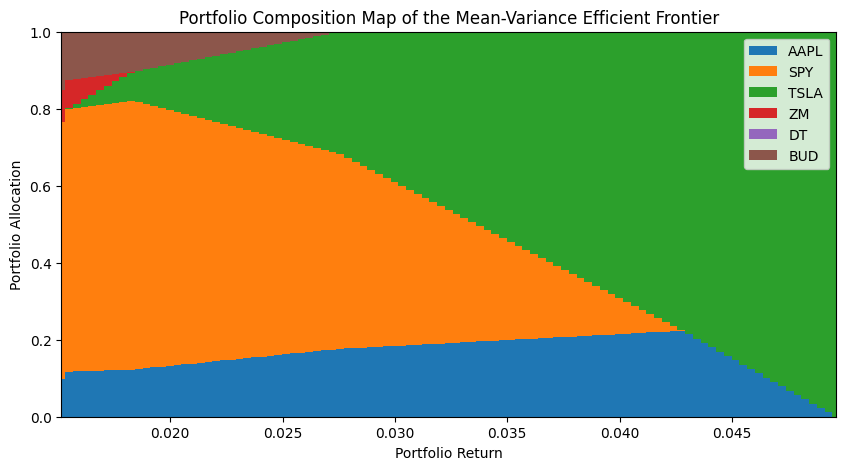

In [78]:
plt.figure(figsize=(10, 5))

# Extract returns and allocations from efficient frontier dataframe
ef_returns = efficient_frontier_df['return'].values
ef_portfolios = efficient_frontier_df[tickers].values

bottom = np.zeros(ef_portfolios.shape[0])
for (i, ticker) in enumerate(tickers):
    plt.bar(x=ef_returns,
            height=ef_portfolios[:,i],
            bottom=bottom,
            label=ticker,
            width=(ef_returns[1] - ef_returns[0]))
    bottom += ef_portfolios[:,i]

plt.legend()
plt.xlabel("Portfolio Return")
plt.xlim(min(ef_returns), max(ef_returns))
plt.ylabel("Portfolio Allocation")
plt.ylim(0, 1)
plt.title("Portfolio Composition Map of the Mean-Variance Efficient Frontier")

plt.show();


## Part 9: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgments are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 10: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.